In [34]:
from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

import torch
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import logomaker
import math
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loading the data and training the model

In [2]:
num_epochs = 10
batch_size = 100 
learning_rate = 0.001 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# data is avaliable from (PMID: 32978299)
x = np.load("../../AI-TAC/ai_tac_data/one_hot_seqs.npy")
x = x.astype(np.float32)
y = np.load("../../AI-TAC/ai_tac_data/cell_type_array.npy")
y = y.astype(np.float32)
peak_names = np.load("../../AI-TAC/ai_tac_data/peak_names.npy")

In [3]:
print(x.shape)
print(y.shape)

(327927, 4, 251)
(327927, 81)


In [4]:
input_length = x.shape[-1]
num_classes = y.shape[-1]

In [5]:
train_data, eval_data, train_labels, eval_labels, train_names, eval_names = train_test_split(x, y, 
                                                                                             peak_names, 
                                                                                             test_size=0.1, 
                                                                                             random_state=40)

# Data loader
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False) #True

eval_dataset = torch.utils.data.TensorDataset(torch.from_numpy(eval_data), torch.from_numpy(eval_labels))
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=False) #True

In [ ]:
# Training models with different number of units
filter_size=19 #20

for num_cnns in range(0,550,50):
    if num_cnns == 0:
        num_cnns = 1

    explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)

    criterion = pearson_loss
    optimizer = torch.optim.Adam(cam_model.parameters(), lr=learning_rate)

    os.makedirs("../../AI_TAC_Models/CAM_AITAC_"+str(num_cnns))
    num_epochs = 10
    
    model, train_error, test_error = train.train_explainn(train_loader, eval_loader, 
                                                          explainn, device, criterion, 
                                                          optimizer, num_epochs,
                                                          "../AI_TAC_Models/CAM_AITAC_"+str(num_cnns)+"/", 
                                                          "", verbose=True, trim_weights=False)
    
    print("Min test error:")
    print(min(test_error))

# Testing

In [ ]:
mean_corr = {}
well_pred = {}

for num_cnns in tqdm(range(0,550,50)):
    if num_cnns == 0:
        num_cnns = 1
    
    model = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
    
    #load the best model
    weight_file = os.listdir("../AI_TAC_Models/CAM_AITAC_"+str(num_cnns)+"/")[0]
    
    model.load_state_dict(torch.load("../AI_TAC_Models/CAM_AITAC_"+str(num_cnns)+"/"+weight_file))
    model.eval();

    predictions, _ = interpretation.get_explainn_predictions(eval_loader, model, device)
    
    correlations = []
    vars = []
    for i in range(len(predictions)):
        var = np.var(eval_labels[i, :])
        vars.append(var)
        x = np.corrcoef(predictions[i, :], eval_labels[i, :])[0, 1]
        correlations.append(x)

    weighted_cor = np.dot(correlations, vars) / np.sum(vars)

    nan_cors = [value for value in correlations if math.isnan(value)]
    correlations = [value for value in correlations if not math.isnan(value)]

    mean_corr[num_cnns] = np.mean(correlations)
    well_pred[num_cnns] = np.where(np.array(correlations) >= 0.75)[0].shape[0]
    
mean_corr = pd.Series(mean_corr)
well_pred = pd.Series(well_pred)

# Interpretation

In [6]:
num_cnns = 300
filter_size = 20

model = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
model.load_state_dict(torch.load("../AI_TAC_Models/CAM_AITAC_300/model_epoch_7_.pth"))
model.eval();

In [7]:
batch_size = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
x = np.load("../../AI-TAC/ai_tac_data/one_hot_seqs.npy")
x = x.astype(np.float32)
y = np.load("../../AI-TAC/ai_tac_data/cell_type_array.npy")
y = y.astype(np.float32)
peak_names = np.load("../../AI-TAC/ai_tac_data/peak_names.npy")

dataset = torch.utils.data.TensorDataset(torch.from_numpy(x), torch.from_numpy(y))
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

In [8]:
predictions, labels = interpretation.get_explainn_predictions(data_loader, model, device)

correlations = []
vars = []
for i in range(len(predictions)):
    var = np.var(labels[i, :])
    vars.append(var)
    x_ = np.corrcoef(predictions[i, :], labels[i, :])[0, 1]
    correlations.append(x_)

In [9]:
correlations = [value for value in correlations if not math.isnan(value)]

#~17K for CAM...
idx = np.argwhere(np.asarray(correlations) > 0.75).squeeze()
idx.shape

(18718,)

In [10]:
x2 = x[idx, :, :]
y2 = y[idx, :]

dataset = torch.utils.data.TensorDataset(torch.from_numpy(x2), torch.from_numpy(y2))
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

In [13]:
activations = interpretation.get_explainn_unit_activations(data_loader, model, device)

pwms = interpretation.get_pwms_explainn(activations, x2, y2, filter_size)
interpretation.pwm_to_meme(pwms, "../CAM_AITAC_ALLW_300_Fig3.meme")

100%|██████████| 300/300 [00:27<00:00, 10.91it/s]


In [ ]:
%%bash
. ~/.bashrc
./../../../meme-5.3.3/src/tomtom -oc ../../../tomtom_results/tomtom_CAM_AITAC_ALLW_300_CISBP_Fig3 ../CAM_AITAC_ALLW_300_Fig3.meme ../../../tomtom_results/CisBP-mouse_NEW.meme

In [18]:
#reading the tomtom results
tomtom_results = pd.read_csv("../../../tomtom_results/tomtom_CAM_AITAC_ALLW_300_CISBP_Fig3/tomtom.tsv",
                                    sep="\t",comment="#")

filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]

tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]

cisbp_motifs = {}
with open("../../../tomtom_results/CisBP-mouse_NEW.meme") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif
            
filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([cisbp_motifs[i] for i in target_id.values])
    annotation[f] = ann
    
filters_ind = np.array([int(i.split("filter")[-1]) for i in annotation.keys()])

annotation = pd.Series(annotation)

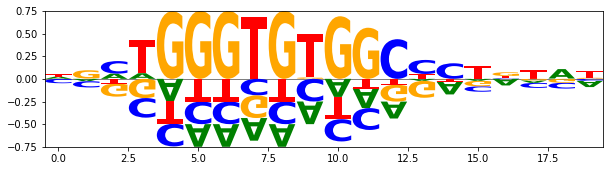

In [13]:
motifs, motif_names = tools.read_meme('../CAM_AITAC_ALLW_300_Fig3.meme')

filterid=39

x = [list(i) for i in motifs[filterid]]
pwm = tools._PWM_to_filter_weights(x, filter_size)
nn_logo = logomaker.Logo(pd.DataFrame(data=pwm,columns = ["A","C", "G","T"]))

## Weights visualization

In [19]:
cell_type_names = ["LTHSC.34-.BM","LTHSC.34+.BM","MMP3.48+.BM","STHSC.150-.BM",
                   "MMP4.135+.BM","proB.CLP.BM","proB.FrA.BM","proB.FrBC.BM",
                   "B.FrE.BM","B1b.PC","B.T1.Sp","B.T2.Sp","B.T3.Sp","B.Sp",
                   "B.Fem.Sp","B.Fo.Sp","B.MZ.Sp","B.GC.CB.Sp","B.GC.CC.Sp",
                   "B.PB.Sp","B.PC.Sp","B.PC.BM","B.mem.Sp","preT.DN1.Th",
                   "preT.DN2a.Th","preT.DN2b.Th","preT.DN3.Th","T.DN4.Th",
                   "T.ISP.Th","T.DP.Th","T.4.Th","T.8.Th","T.4.Nve.Sp","T.4.Nve.Fem.Sp",
                   "T.4.Sp.aCD3+CD40.18hr","Treg.4.FP3+.Nrplo.Co","Treg.4.25hi.Sp",
                   "T.8.Nve.Sp","T8.TN.P14.Sp","T8.IEL.LCMV.d7.Gut","T8.TE.LCMV.d7.Sp",
                   "T8.MP.LCMV.d7.Sp","T8.Tcm.LCMV.d180.Sp","T8.Tem.LCMV.d180.Sp",
                   "NKT.Sp","NKT.Sp.LPS.3hr","NKT.Sp.LPS.18hr","NKT.Sp.LPS.3d",
                   "Tgd.g2+d17.24a+.Th","Tgd.g2+d17.LN","Tgd.g2+d1.24a+.Th",
                   "Tgd.g2+d1.LN","Tgd.g1.1+d1.24a+.Th","Tgd.g1.1+d1.LN","Tgd.Sp",
                   "NK.27+11b-.BM","NK.27+11b+.BM","NK.27-11b+.BM","NK.27+11b-.Sp",
                   "NK.27+11b+.Sp","NK.27-11b+.Sp","ILC2.SI","ILC3.NKp46-CCR6-.SI",
                   "ILC3.NKp46+.SI","ILC3.CCR6+.SI","GN.BM","GN.Sp","GN.Thio.PC",
                   "Mo.6C+II-.Bl","Mo.6C-II-.Bl","MF.PC","MF.Fem.PC",
                   "MF.226+II+480lo.PC","MF.102+480+.PC","MF.RP.Sp","MF.Alv.Lu",
                   "MF.pIC.Alv.Lu","MF.microglia.CNS","DC.4+.Sp","DC.8+.Sp","DC.pDC.Sp"]

model = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
model.load_state_dict(torch.load("../AI_TAC_Models/CAM_AITAC_300/model_epoch_7_.pth"))
model.eval();

annotation_new_ind = [int(i.split("filter")[-1]) for i in annotation.index]
filter_dict_300 = annotation
filter_dict_300.index = annotation_new_ind

weights = model.final.weight.detach().cpu().numpy()

filters = [str(i) for i in range(300)] #num_cnns=300
for i in filter_dict_300.keys():
    filters[i] = filter_dict_300[i]
    
cell_line = pd.read_excel('../../AI-TAC/TableS4_lineageCells.xlsx', header = 2,index_col=0)
lineage_names = list(cell_line.loc[cell_type_names,:]["lineageModel"].values)

with open('../../AI-TAC/ATAC_Data_Intensity_FilteredPeaksLogQuantile.txt', 'r') as tsv:
    columns=tsv.readline().split('\t')
columns = columns[1:]
columns = [i.strip() for i in columns]

In [22]:
weight_df = pd.DataFrame(weights,index=columns,columns=filters)

weight_df = weight_df.reindex(cell_type_names)

lut = dict(zip(set(lineage_names), sns.hls_palette(len(set(lineage_names)), l=0.7, s=0.9)))
row_colors = pd.DataFrame(lineage_names)[0].map(lut)

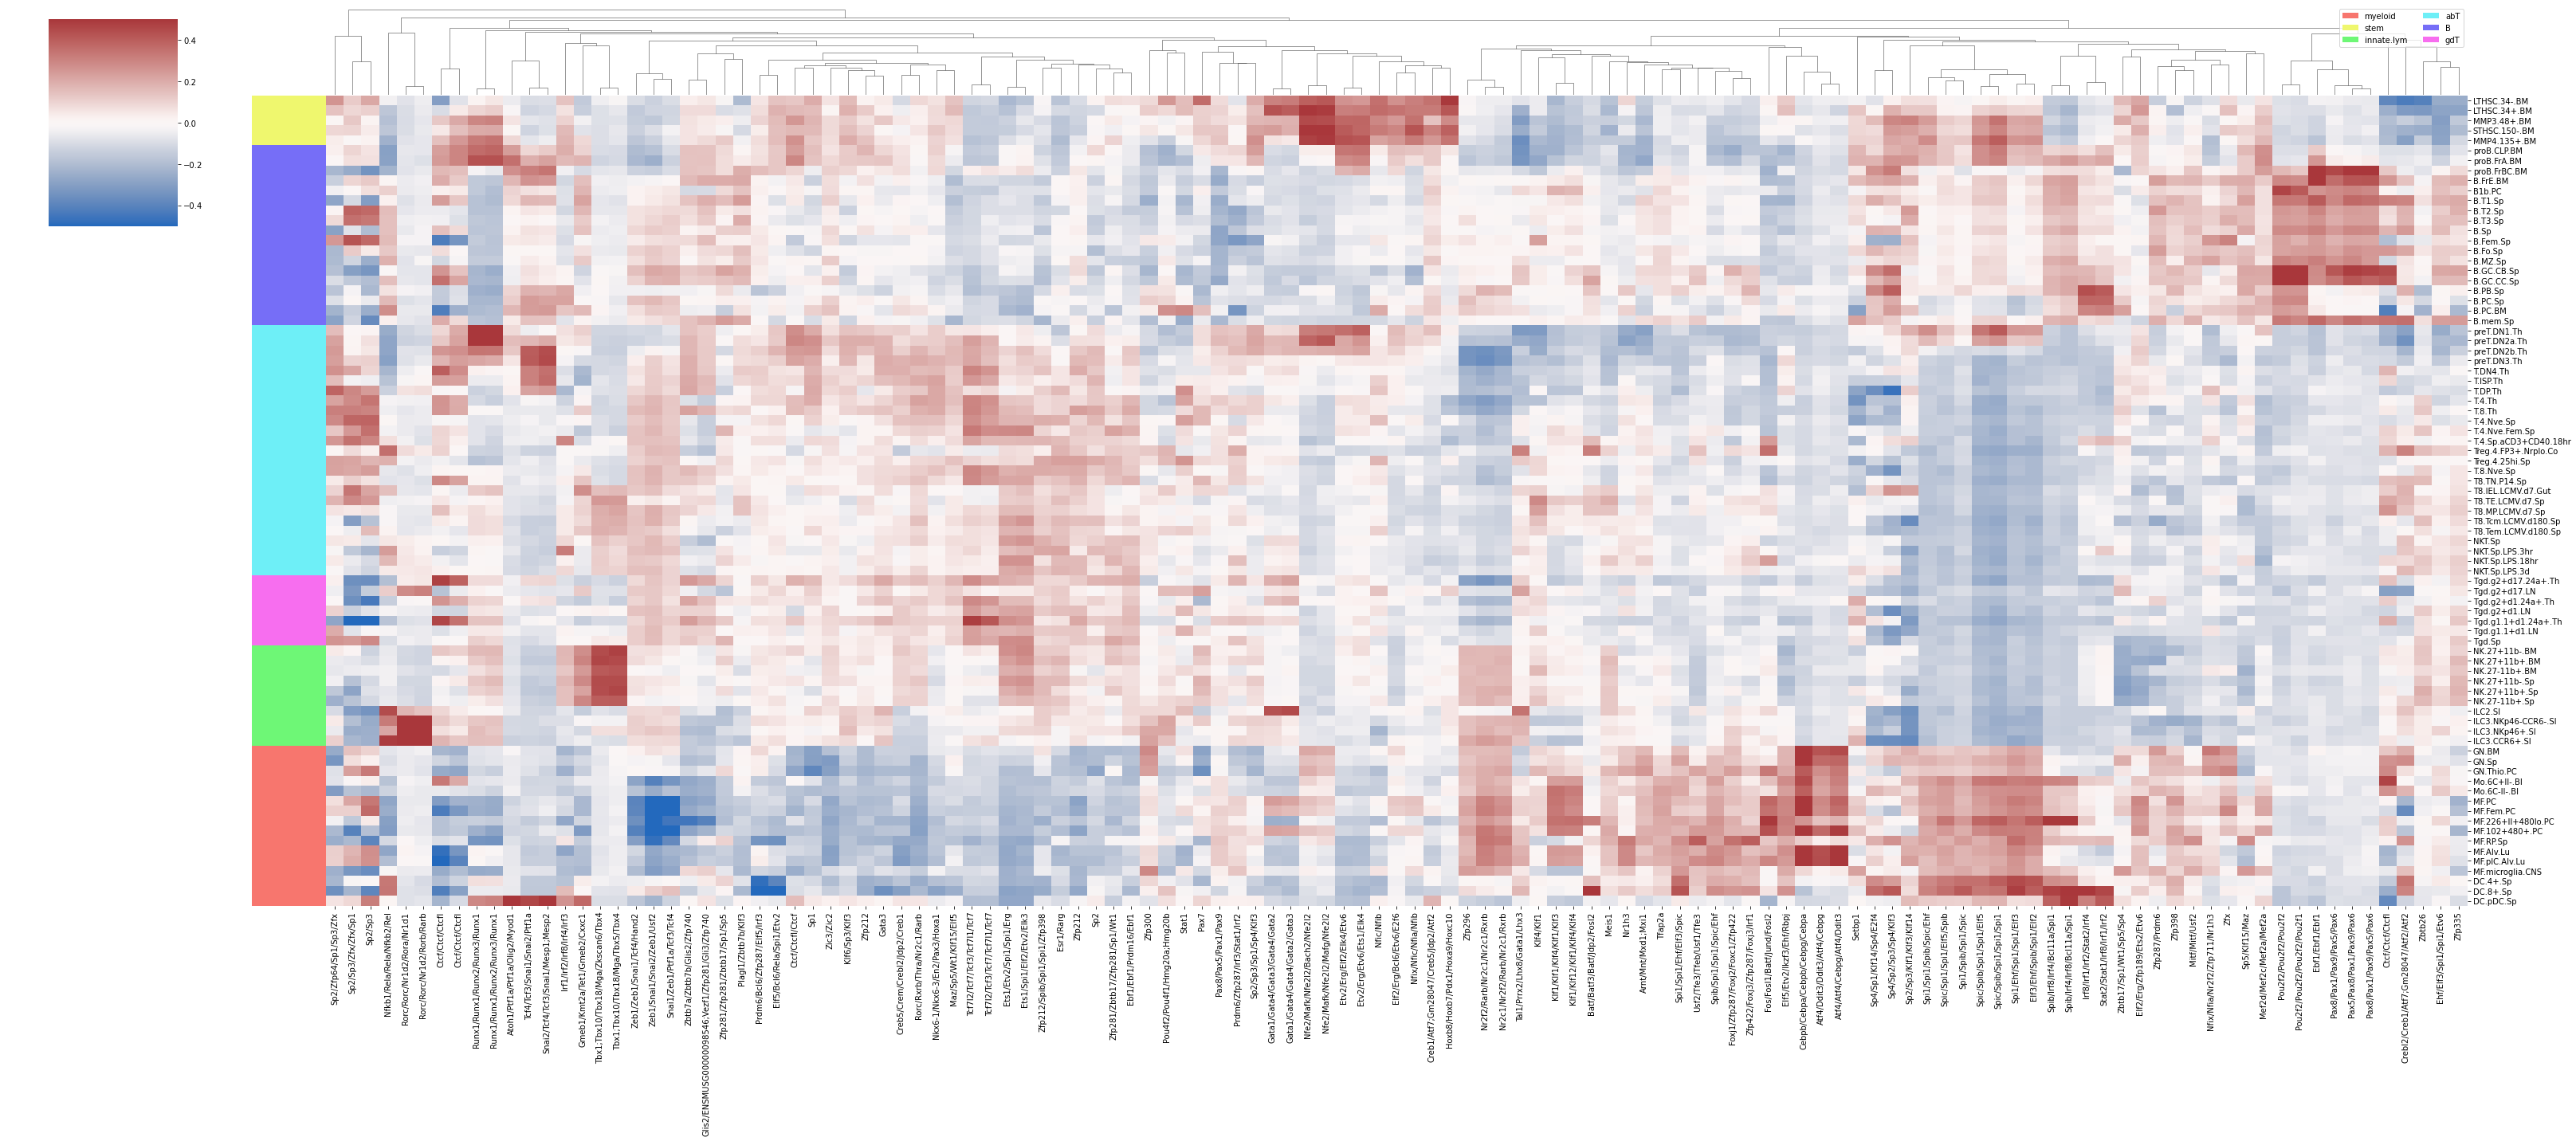

In [24]:
ann_wdf = weight_df.loc[:,[not i.isnumeric() for i in list(weight_df)]]

ax = sns.clustermap(ann_wdf,row_cluster=False,row_colors=row_colors.values,
                    cmap='vlag',
                    figsize=(45,20), 
                    vmax=0.5, vmin=-0.5,
                    yticklabels=True,xticklabels=True,dendrogram_ratio=0.1)

for label in set(lineage_names):
    ax.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)

ax.ax_col_dendrogram.legend(loc="best", ncol=2)

## Unit Importance

In [28]:
activations  = interpretation.get_explainn_unit_activations(data_loader, model, device)
unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, model, device)

100%|██████████| 188/188 [00:03<00:00, 48.13it/s]


In [ ]:
for filt in tqdm(range(300)):
    res_distr = interpretation.get_specific_unit_importance(activations, model, unit_outputs, filt, columns)

    filter_key = "filter"+str(filt)
    title = annotation[filter_key] if filter_key in annotation.index else filter_key
    fig, ax = plt.subplots()
    datas = [filt_dat for filt_dat in res_distr]
    ax.boxplot(datas, notch=True, patch_artist=True)
    fig.set_size_inches(18.5, 10.5)
    plt.title(title)
    plt.ylabel("Filter importance")
    plt.xticks(range(1, 82), cell_type_names)
    plt.xticks(rotation=90)
    fig.savefig('../CAM_AITAC_300_FI/'+filter_key+'.png')